<h1>Task 1: Dataset Selection and Preparation (20 Marks)</h1>

In [4]:
import pandas as pd

# Load dataset
df = pd.read_csv('Malaysia_restaurant_review.csv')

# Shows column names, non-null counts, and data types
df.info()

# Statistical summary for numeric columns
df.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Author      1902 non-null   object
 1   Review      1869 non-null   object
 2   Rating      1902 non-null   object
 3   Restaurant  1902 non-null   object
 4   Location    1902 non-null   object
dtypes: object(5)
memory usage: 74.4+ KB


,Author,Review,Rating,Restaurant,Location
count,1902,1869,1902,1902,1902
unique,1850,1838,5,9,9
top,Yc Yong,Nice food,"Rated 5.0 out of 5,",Hadramawt Kitchen Shah Alam-Middle Eastern Res...,"Jalan Penguasa A U1/53A, Kawasan Perindustrian..."
freq,3,8,929,300,300


In [5]:
# Check number of missing values
print("Missing values per column:\n", df.isnull().sum())

# Handle missing values for each column
# Author -> text, replace missing with 'unknown'
df['Author'] = df['Author'].fillna('unknown')

# Review -> text, replace missing with empty string
df['Review'] = df['Review'].fillna('')

# Rating -> numeric-like, convert to float, replace missing with 0
df['Rating'] = df['Rating'].str.extract(r'([\d.]+)').astype(float)
df['Rating'] = df['Rating'].fillna(0)

# Restaurant -> text, replace missing with 'unknown'
df['Restaurant'] = df['Restaurant'].fillna('unknown')

# Location -> text, replace missing with 'unknown'
df['Location'] = df['Location'].fillna('unknown')

Missing values per column:
 Author         0
Review        33
Rating         0
Restaurant     0
Location       0
dtype: int64


<h3>I chose to use the fillna() for handling the missing values because it keeps all rows in the dataset while replacing missing values with sensible defaults (e.g., empty string for text, 0 for numbers). This prevents errors during analysis or model training and avoids losing useful information by dropping rows.</h3>

<h1>Task 2: Data Aggregation and Analysis (20 Marks)</h1>

In [7]:
# 1. Average Rating per Restaurant
# Shows which restaurants generally provide the best customer experience.
avg_rating_per_restaurant = df.groupby('Restaurant')['Rating'].mean().round(2).sort_values(ascending=False)
print("\n1. Average Rating per Restaurant:\n", avg_rating_per_restaurant)

# 2. Number of Reviews per Restaurant
# Helps identify restaurant popularity and customer traffic based on how many people left reviews.
reviews_per_restaurant = df['Restaurant'].value_counts()
print("\n2. Number of Reviews per Restaurant:\n", reviews_per_restaurant)

# 3. Average Rating per Location
# Shows which restaurant branches or areas provide better service quality.
avg_rating_per_location = df.groupby('Location')['Rating'].mean().round(2).sort_values(ascending=False)
print("\n3. Average Rating per Location:\n", avg_rating_per_location)

# 4. Distribution of Ratings (Overall)
# Helps understand overall customer satisfaction by analyzing how ratings are spread out.
rating_distribution = df['Rating'].value_counts().sort_index()
print("\n4. Distribution of Ratings:\n", rating_distribution)

# 5. Top 5 Restaurants with Most 5-Star Ratings
# Identifies restaurants most frequently praised with top reviews.
top_5star_restaurants = df[df['Rating'] == 5].groupby('Restaurant').size().sort_values(ascending=False).head(5)
print("\n5. Top 5 Restaurants with Most 5-Star Ratings:\n", top_5star_restaurants)


1. Average Rating per Restaurant:
 Restaurant
Hadramawt Kitchen Shah Alam-Middle Eastern Restaurant    4.59
Ti Chen                                                  4.44
Buns & Noodles                                           4.31
Senja Restaurant @ The Saujana Hotel Kuala Lumpur        4.30
Ole-Ole Bali @ Empire Shopping Gallery                   4.21
ALRAWSHA RESTAURANT                                      4.15
Fatty Mee Hoon Kuih House (Klang)                        4.14
Melting Pot Cafe, Concorde Hotel                         4.04
Restoran Boston Baru                                     3.66
Name: Rating, dtype: float64

2. Number of Reviews per Restaurant:
 Restaurant
Hadramawt Kitchen Shah Alam-Middle Eastern Restaurant    300
Ole-Ole Bali @ Empire Shopping Gallery                   300
Fatty Mee Hoon Kuih House (Klang)                        300
ALRAWSHA RESTAURANT                                      291
Restoran Boston Baru                                     291
Buns & Nood

<h1>Task 3: Sentiment Analysis with Hugging Face (30 Marks)</h1>

In [20]:
# Task 3: Sentiment Analysis with Hugging Face (Cleaned & Improved)

from transformers import pipeline
import re

# 1. Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", 
                              model="nlptown/bert-base-multilingual-uncased-sentiment",
                              device=-1)  # force CPU to avoid GPU issues

# 2. Clean reviews (remove Google Translate artifacts)
def clean_review(text):
    text = re.sub(r'\(Translated by Google\)', '', text)
    text = re.sub(r'\(Original\)', '', text)
    return text.strip()

df['Cleaned_Review'] = df['Review'].astype(str).apply(clean_review)

# 3. Run sentiment analysis in batches
reviews = df['Cleaned_Review'].tolist()
batch_size = 32
results = []
for i in range(0, len(reviews), batch_size):
    batch = reviews[i:i+batch_size]
    outputs = sentiment_pipeline(batch, truncation=True)
    results.extend(outputs)

# 4. Store results in DataFrame
df['Sentiment'] = [res['label'] for res in results]
df['Sentiment_Score'] = df['Sentiment'].str.extract(r'(\d)').astype(int)

# Show Top 5 Reviews (Most Positive)
print("Top 5 Reviews (Most Positive):")
top_5 = df.sort_values(by="Sentiment_Score", ascending=False).head(5).reset_index(drop=True)
top_5.index = range(1, len(top_5) + 1)
display(top_5[["Author", "Restaurant", "Review", "Sentiment_Score"]])

# Show Bottom 5 Reviews (Most Negative)
print("Bottom 5 Reviews (Most Negative):")
bottom_5 = df.sort_values(by="Sentiment_Score", ascending=True).head(5).reset_index(drop=True)
bottom_5.index = range(1, len(bottom_5) + 1)
display(bottom_5[["Author", "Restaurant", "Review", "Sentiment_Score"]])

Device set to use cpu


Top 5 Reviews (Most Positive):


,Author,Restaurant,Review,Sentiment_Score
1,Mohamad Hariz Nor Hisham,"Melting Pot Cafe, Concorde Hotel",(Translated by Google) Book asyuk(Original)Boe...,5
2,mukmin abdul,"Melting Pot Cafe, Concorde Hotel",(Translated by Google) Beautiful hotel(Origina...,5
3,Mohd Azlan Abu Bakar,Hadramawt Kitchen Shah Alam-Middle Eastern Res...,Fantastic place which have been my go to place...,5
4,Antony Lim,Hadramawt Kitchen Shah Alam-Middle Eastern Res...,"Came here during dinner time on weekdays, not ...",5
5,狐鸣,Hadramawt Kitchen Shah Alam-Middle Eastern Res...,Have ordered from this place multiple times du...,5


Bottom 5 Reviews (Most Negative):


,Author,Restaurant,Review,Sentiment_Score
1,ARIEF MD NOR,Hadramawt Kitchen Shah Alam-Middle Eastern Res...,Dinner with colleagues a week before resign,1
2,Jonathan Yap,Ole-Ole Bali @ Empire Shopping Gallery,Chicken was dried and food was below average.I...,1
3,Sulis Rubi,Hadramawt Kitchen Shah Alam-Middle Eastern Res...,"I ate the chiken mandhi, drink coffee, tea, pi...",1
4,James Noah,Hadramawt Kitchen Shah Alam-Middle Eastern Res...,Iove this place it is my 6th time but today i ...,1
5,Jasmine,Restoran Boston Baru,we've made reservation and waiting time is 1++...,1


<h1>Task 4: Interactive Visualisation with Plotly (20 Marks)</h1>

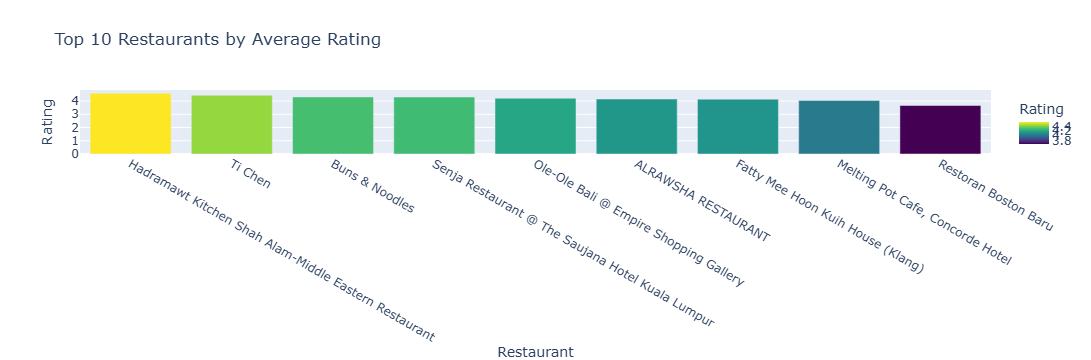

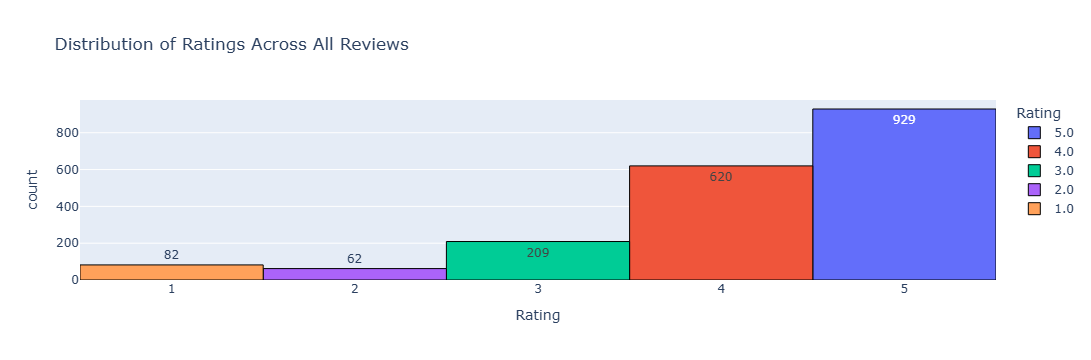

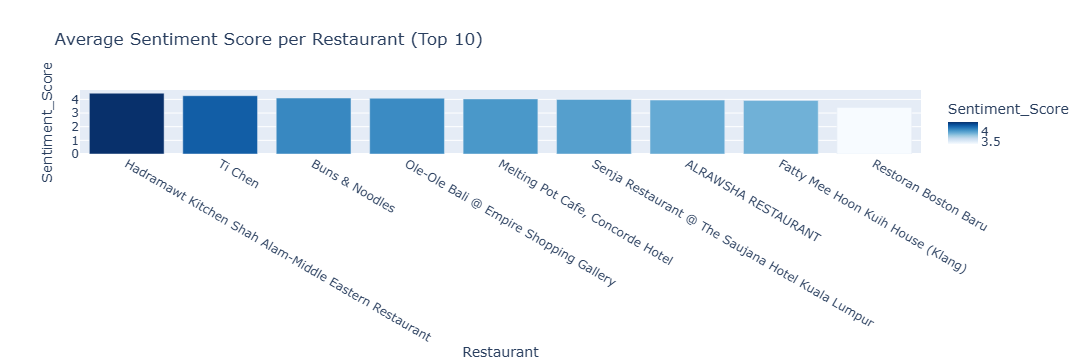

In [32]:
# Task 4: Interactive Visualisation with Plotly

import plotly.express as px
import plotly.graph_objects as go

# 1. Average Rating per Restaurant (Bar Chart)
fig1 = px.bar(avg_rating_per_restaurant.head(10).reset_index(),
              x="Restaurant", y="Rating",
              title="Top 10 Restaurants by Average Rating",
              color="Rating",
              color_continuous_scale="Viridis")
fig1.show()
# Interpretation:
# This chart shows which restaurants consistently deliver the best customer experiences
# by averaging their ratings. Higher bars = better overall satisfaction.

# 2. Distribution of Ratings (Interactive Histogram)
fig2 = px.histogram(df, x="Rating",
                    nbins=5, 
                    title="Distribution of Ratings Across All Reviews",
                    color="Rating",
                    text_auto=True)
fig2.update_traces(marker_line_width=1, marker_line_color="black")
fig2.show()
# Interpretation:
# This plot reveals how customer ratings are spread (e.g., more 5-star vs. low ratings).
# A skew toward higher values indicates general customer satisfaction.


# 3. Average Sentiment Score per Restaurant (Bar Chart)
avg_sentiment = df.groupby("Restaurant")["Sentiment_Score"].mean().sort_values(ascending=False).reset_index()

fig3 = px.bar(avg_sentiment.head(10),  # show top 10 restaurants
              x="Restaurant", y="Sentiment_Score",
              title="Average Sentiment Score per Restaurant (Top 10)",
              color="Sentiment_Score",
              color_continuous_scale="Blues")
fig3.show()

# Interpretation:
# This bar chart displays the top 10 restaurants ranked by their average sentiment scores.
# This helps identify which restaurants consistently provide positive experiences and which ones may need improvement based on customer feedback.